In [61]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba.typed import List
import time
from numba.typed import Dict
from numba.core import types
import numba

In [76]:

@jit(nopython=True)
def combinations(node_list):
    comb_list=List.empty_list(types.int32)
    for  indx,i in enumerate(node_list):
        for j in node_list[indx+1:]:
            comb_list.append(j)
            comb_list.append(i)
            
    return comb_list

In [ ]:
combinations

In [63]:
@jit(nopython=True)
def initialize_graph(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, num_initial_nodes: int):
    """
    Create inital regular graph with num_initial_nodes nodes, one group and aa inter group connections.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections as the ordered pairs => [n1,n2,n1,n3] when n1 is connected with n2 and n3

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps as many observations of node grom this specific group as many connections this node has to other nodes.
    
    num_initial_nodes: initial number of nodes in graph.

    """
    #create initial regular graph
    for ii in np.arange(num_initial_nodes):
        gr_dict[ii]=0
    
    for val in combinations(np.arange(num_initial_nodes)):
        n_list.append(val)
    
    #create group zero with initial nodes
    gr_list.append(n_list.copy())
    

In [64]:
@jit(nopython=True)
def add_global_connections(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, bb: int, new_node_id :int, new_node_group_id :int, initial_length: int):
    """
    Add global connections to the newly created node.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections as the ordered pairs => [n1,n2,n1,n3] when n1 is connected with n2 and n3

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps as many observations of node grom this specific group as many connections this node has to other nodes.
    
    bb: number of global connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    new_node_group_id: ID of group of the added node for which we are creating connections.
    
    initial_length: Length of the node vector in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """
    indexes=List()
    
    for ii in np.arange(0,bb):
        # if np.random.random()<10**(-3):
        ind=np.random.randint(0,initial_length)
        indexes.append(ind)

        #append selected connections to the list 
    for indx in indexes:
        node_id=n_list[indx]
        n_list.append(node_id)
        gr_list[gr_dict[node_id]].append(node_id)
        n_list.append(new_node_id)
        gr_list[new_node_group_id].append(new_node_id)



In [65]:
@jit(nopython=True)
def add_new_group_connections(n_list: numba.typed.typedlist.List ,gr_list: numba.typed.typedlist.List, aa: int, new_node_id: int, new_group_id: int, initial_group_length: int):
    """
    Add connections to the newly created node in the newly created group obtained by adding bunch of new nodes to the graph.

   Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections as the ordered pairs => [n1,n2,n1,n3] when n1 is connected with n2 and n3

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps as many observations of node grom this specific group as many connections this node has to other nodes.
    
    aa: number of in group connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    new_group_id: ID of group of the added node for which we are creating connections.
    
    initial_group_length: Length of the new_group list in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """
    indexes=List()

    #proportional attachment of a connections inside newly created group
    for ii in np.arange(0,aa):
        ind=np.random.randint(0,initial_group_length)
        indexes.append(ind)
        
    #append created connections to the list
    for indx in indexes:
        node_id=gr_list[new_group_id][indx]
        n_list.append(node_id)
        gr_list[new_group_id].append(node_id)
        gr_list[new_group_id].append(new_node_id)
        n_list.append(new_node_id)
        


In [66]:
@jit(nopython=True)
def add_old_group_connections(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, aa: int, new_node_id: int, initial_length: int):
    """
    Add connections to the newly created node in the preselected preexisting group.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections as the ordered pairs => [n1,n2,n1,n3] when n1 is connected with n2 and n3

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps as many observations of node grom this specific group as many connections this node has to other nodes.
    
    aa: number of in group connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    initial_length: Length of the node vector in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """   
    indexes=List()
    
    #initial node to which our new node will attach, selected from all of the nodes with the preference
    initial_index=np.random.randint(0,initial_length)
    group_id=gr_dict[n_list[initial_index]]
    
    #attach the new node to the same group as the group of the initial node
    gr_dict[new_node_id]=group_id
    
    #select more nodes from selected group
    for ii in np.arange(0,aa-1):
        # ind=np.random.randint(0,init_gr_len[group_id])
        ind=np.random.randint(0,len(gr_list[group_id]))
        indexes.append(ind)
    
    #append initial connection to the list
    n_list.append(n_list[initial_index])
    n_list.append(new_node_id)
    gr_list[group_id].append(n_list[initial_index])
    gr_list[group_id].append(new_node_id)
    
    #append created connections to the lists
    for indx in indexes:
        node_id=gr_list[group_id][indx]
        n_list.append(node_id)
        gr_list[group_id].append(node_id)
        n_list.append(new_node_id)
        gr_list[group_id].append(new_node_id)
    
        


In [67]:
@jit(nopython=True)
def proportional_attach(node_list: numba.typed.typedlist.List, group_dict: numba.typed.typeddict.Dict ,groups: numba.typed.typedlist.List, mm: int,aa: int,bb: int,pp: float):
    """
    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections as the ordered pairs => [n1,n2,n1,n3] when n1 is connected with n2 and n3

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps as many observations of node grom this specific group as many connections this node has to other nodes.
    
    mm: number of nodes added in each step.
    
    aa: number of in group connections created by the new node.
    
    bb: number of global connections created by the new node.
    
    pp: probability that newly added nodes will create a new group.

    """ 
    #initial length of an node_list, lets us get proportial attachment on the basis of the old list for each of the new added nodes
    length_init=len(node_list)-1
    #until you reach number of nodes which should be added

    #decide whether we want to append this point to existing group or create new group
    if np.random.random()<1-pp:
        #create new group for new nodes
        groups.append(List.empty_list(types.int32))
        new_group_id=len(groups)-1
        created_nodes=List.empty_list(types.int32)
        for node in np.arange(mm):
            # indexes=List()
            #number of added node
            added_node=len(group_dict)
            created_nodes.append(added_node)
            group_dict[added_node]=new_group_id
            
            add_global_connections(node_list,group_dict,groups,bb,added_node,new_group_id,length_init)
            
        
        #create connections inside group, we create full graph from all of the nodes
        for node_id in combinations(created_nodes):
            node_list.append(node_id)
            groups[new_group_id].append(node_id)
        
        # group_size_dict[new_group_id]=len(groups[new_group_id])
        # for added_node in created_nodes:
            # add_new_group_connections(node_list, groups, aa, added_node, new_group_id, init_group_length)
    else:
        created_nodes=List.empty_list(types.int32)
        for node in np.arange(mm):
            
            #number of added node
            added_node=len(group_dict)
            created_nodes.append(added_node)
            
            add_old_group_connections(node_list,group_dict, groups, aa, added_node, length_init)
            
        for added_node in created_nodes:

            add_global_connections(node_list,group_dict,groups,bb,added_node,group_dict[added_node],length_init)
                    



In [96]:
node_list=List.empty_list(types.int32)

group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)

group_size_dict = Dict.empty(
key_type=types.int64,
value_type=types.int64,
)

groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))
initial_nodes=4
n_nodes=10**6
a=3
b=1
m=a+1
p=0.5

initialize_graph(node_list, group_dict, groups, initial_nodes)
for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
    proportional_attach(node_list,group_dict,groups,m,a,b,p)

100%|██████████| 250000/250000 [00:04<00:00, 52584.29it/s]


In [79]:
node_list=List.empty_list(types.int32)
initialize_graph(node_list, group_dict, groups, initial_nodes)

In [80]:
node_list

ListType[int32]([1, 0, 2, 0, 3, 0, 2, 1, 3, 1, 3, 2, ...])

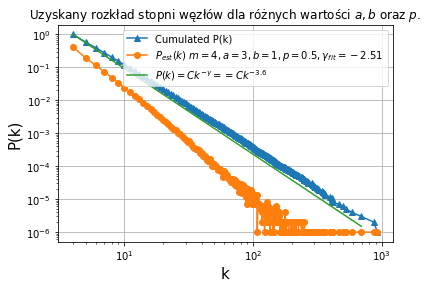

In [97]:
plot_degree_distr(node_list,a,b,p,m)

# Degree and group size distribution

In [94]:
def plot_degree_distr(node_list,a,b,p,m): 
    vals,counts=np.unique(node_list,return_counts=True)
    vals,counts=np.unique(counts,return_counts=True)

    prob=counts/np.sum(counts)
    cum_sum=np.cumsum(prob[::-1])[::-1]
    gamma=2+(a+b)/(p*a+b)
    plt.loglog(vals,cum_sum,"^-",label="Cumulated P(k)")

    logx = np.log(vals)
    logy = np.log(prob)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    # plt.loglog(vals,yfit(vals),label=f"$P_{{fit}}(k) \gamma={np.round(coeffs[0],2)}(2)$")
    # y_pred = (prob[0])*vals[0]**gamma/vals**(gamma)
    y_pred = (cum_sum[0])*vals[0]**(gamma-1)/vals**(gamma-1)
    plt.loglog(vals,prob,"o-",label=f"$P_{{est}}(k)$ $m={m}, a={a}, b={b}, p={p}, \gamma_{{fit}}={np.round(coeffs[0],2)}$")
    plt.loglog(vals[y_pred>10**(-6)],y_pred[y_pred>10**(-6)], label=f"$P(k)=Ck^{{- \gamma }}==Ck^{{- {np.round(gamma,2)} }}$")
    # plt.loglog(vals,yfit(vals),label=f"$P_{{fit}}(k) \gamma={np.round(coeffs[0],2)}(2)$")

    plt.legend()
    plt.grid()
    plt.xlabel("k",fontsize=15)
    plt.ylabel("P(k)",fontsize=15)
    plt.title(f"Uzyskany rozkład stopni węzłów dla różnych wartości $a, b$ oraz $p$.")

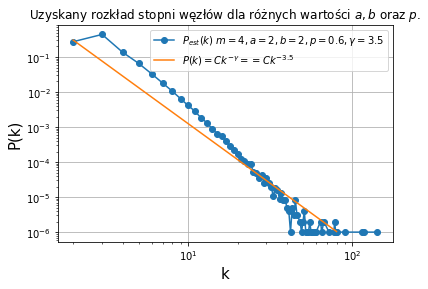

In [9]:
def plot_group_size_distr(groups,a,b,p,m): 
    group_size_list=[len(np.unique(subgroup)) for subgroup in groups]
    vals,counts=np.unique(group_size_list,return_counts=True)
    # vals,counts=np.unique(counts,return_counts=True)
    prob=counts/np.sum(counts)
    # cum_sum=np.cumsum(prob[::-1])[::-1]
    # plt.loglog(vals,cum_sum,"^-",label="Cumulated P(G)")

    logx = np.log(vals)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    plt.loglog(vals,prob,"o-",label=f"$P(G)$ $m={m}, a={a}, b={b}, p={p}, \gamma={np.round(gamma,2)}$")
    # plt.loglog(vals,yfit(vals))
    plt.legend()
    plt.grid()
    plt.xlabel("G",fontsize=15)
    plt.ylabel("P(G)",fontsize=15)
    plt.title(f"Uzyskany rozkład rozmiaru grup dla różnych wartości $a, b$ oraz $p$.")
    


NameError: name 'groups' is not defined

In [ ]:
plot_group_size_distr(groups,a,b,p,m)

100%|██████████| 250000/250000 [00:09<00:00, 26591.39it/s]


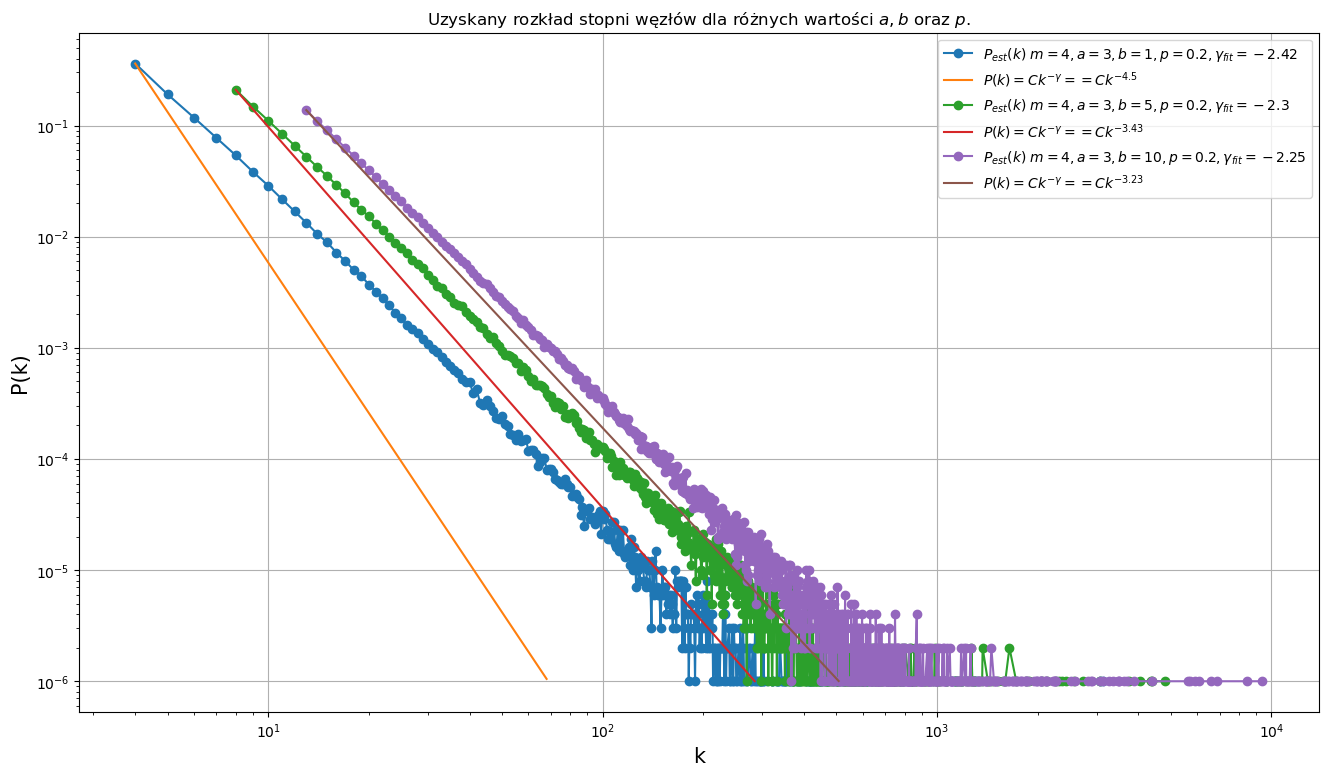

In [41]:
n_nodes=10**6
p=0.2
a=3

b_list=[1,5,10]
a_list=[2,5,7]
plt.figure(figsize=(16,9),dpi= 100)
for b in b_list:
    m=a+1
    initial_nodes=m
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )

    group_size_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
    )

    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))
    initialize_graph(node_list, group_dict, groups, initial_nodes)
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    
    plot_degree_distr(node_list,a,b,p,m)
    # plot_group_size_distr(groups,a,b,p,m)

100%|██████████| 333334/333334 [00:04<00:00, 75856.84it/s]


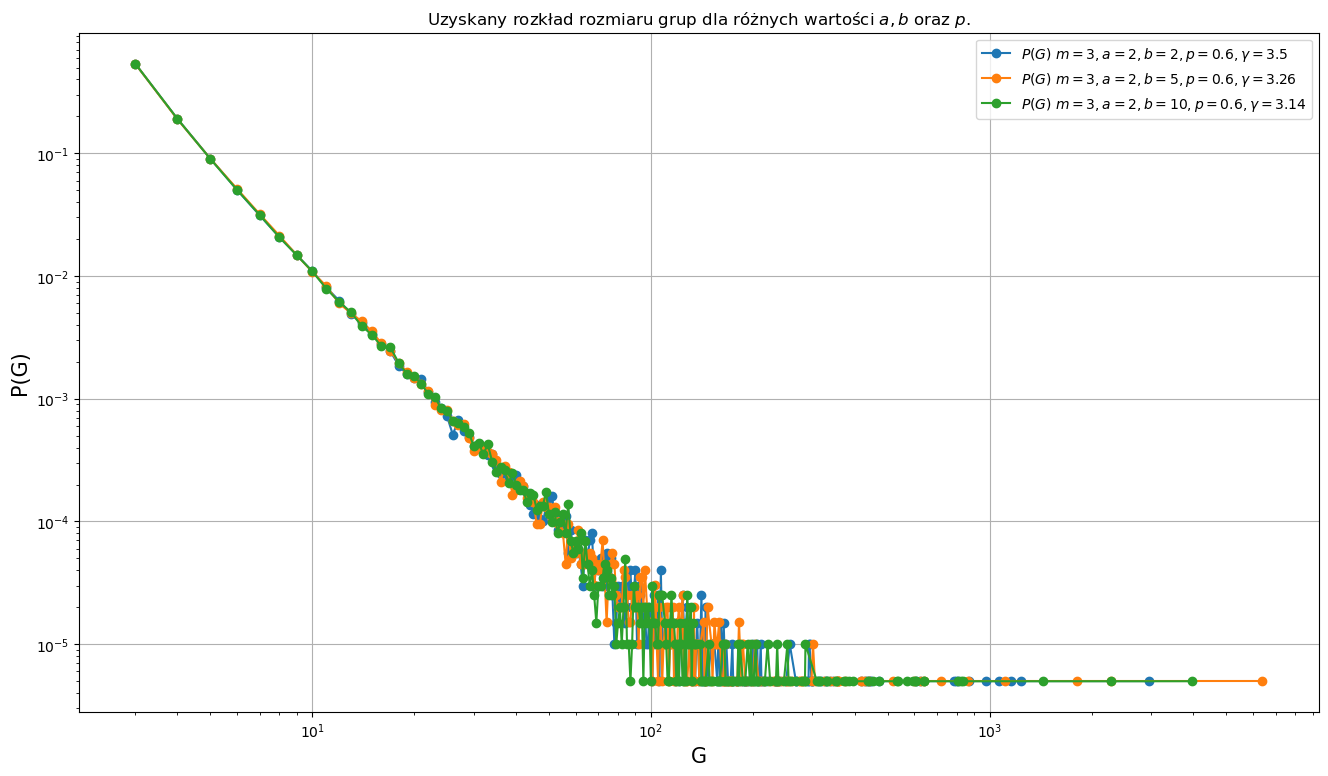

In [14]:
n_nodes=10**6
p=0.6
a=2
m=a+1
b_list=[2,5,10]
a_list=[2,5,7]
plt.figure(figsize=(16,9),dpi= 100)
for b in b_list:
    
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )

    group_size_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
    )

    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))
    initialize_graph(node_list, group_dict, groups, initial_nodes)
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    
    # plot_degree_distr(node_list,a,b,p,m)
    plot_group_size_distr(groups,a,b,p,m)

# Graph properties study

In [11]:
#saving output to the file !!!!!!!!!!!!!!!!!!!
for a in tqdm(np.array([2,4,6])):
    initial_nodes=4
    n_nodes=10**5

    #parameters
    b=1
    p=0.2
    m=a+1
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )
    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

    initialize_graph(node_list, group_dict, groups, initial_nodes)    
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    file_name=f'out_graph_p_0{int(10*p)}_a_{a}_b_{b}.txt'
    with open(file_name, 'a') as data:
        # for node_1, node_2 in zip(node_list,node_list[::2]): 
        for ii in range(0,len(node_list),2):
            # data.write(f'{node_1}\t{node_2}\n')
            data.write(f'{node_list[ii]}\t{node_list[ii+1]}\n')

100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


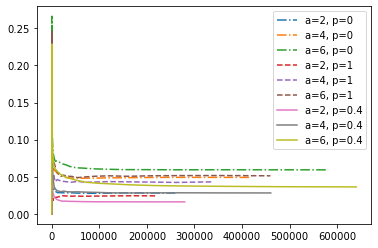

In [ ]:

from collections import Counter
from collections import defaultdict
plt.figure()
# file_names=['out_graph_p_00_a_2_b_1.txt','out_graph_p_00_a_4_b_1.txt','out_graph_p_00_a_6_b_1.txt','out_graph_p_010_a_2_b_1.txt','out_graph_p_010_a_4_b_1.txt','out_graph_p_010_a_6_b_1.txt','out_graph_p_04_a_2_b_1.txt','out_graph_p_04_a_4_b_1.txt','out_graph_p_04_a_6_b_1.txt']
# file_names=['out_graph_p_00_a_2_b_0.txt','out_graph_p_00_a_4_b_0.txt','out_graph_p_00_a_6_b_0.txt','out_graph_p_010_a_2_b_0.txt','out_graph_p_010_a_4_b_0.txt','out_graph_p_010_a_6_b_0.txt','out_graph_p_04_a_2_b_0.txt','out_graph_p_04_a_4_b_0.txt','out_graph_p_04_a_6_b_0.txt']
file_names=['out_graph_p_04_a_2_b_1.txt','out_graph_p_04_a_4_b_1.txt','out_graph_p_04_a_6_b_1.txt',
            'out_graph_p_08_a_2_b_1.txt','out_graph_p_08_a_4_b_1.txt','out_graph_p_08_a_6_b_1.txt',
            'out_graph_p_02_a_2_b_1.txt','out_graph_p_02_a_4_b_1.txt','out_graph_p_02_a_6_b_1.txt']

# file_names=['out_graph_p_00_a_2_b_1.txt']
for file, a, p in zip(file_names,[2,4,6,2,4,6,2,4,6],[0,0,0,1,1,1,0.4,0.4,0.4]):
    xx = open_file(file)
    ll=[]
    for ii in np.logspace(0,np.log10(len(xx)),50,dtype=int):
        d = defaultdict(lambda : 0)
        for val in xx[:ii]:
            d[val]+=1
        ll.append(d)
    duplicates_num=[]
    for val, size in zip(ll,np.logspace(0,np.log10(len(xx)),50,dtype=float)):
        duplicates_num.append((sum(np.array(list(val.values()))>1))/size)
    if(p==1):
        style='--'
    elif (p==0):
        style='-.'  
    else:
        style='-'
    
    plt.plot(np.logspace(0,np.log10(len(xx)),50,dtype=int), duplicates_num,label=f'a={a}, p={p}',linestyle=style)
plt.legend()

In [ ]:
gamma_list=[]
gamma_list_groups=[]
for p in tqdm(np.arange(0,1.02,0.05)):
    initial_nodes=4
    n_nodes=10**5

    #parameters
    b=1
    m=4
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )
    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

    initialize_graph(node_list, group_dict, groups, initial_nodes)    
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    vals,counts=np.unique(node_list,return_counts=True)
    vals,counts=np.unique(counts,return_counts=True)
    prob=counts/np.sum(counts)
    cum_sum=np.cumsum(prob[::-1])[::-1]
    logx = np.log(vals)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    gamma_list.append(coeffs[0])
    
    group_size_list=[len(subgroup) for subgroup in groups]
    vals,counts=np.unique(group_size_list,return_counts=True)
    # vals,counts=np.unique(counts,return_counts=True)
    prob=counts/np.sum(counts)
    cum_sum=np.cumsum(prob[::-1])[::-1]

    logx = np.log(vals)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    gamma_list_groups.append(coeffs[0])

100%|██████████| 25000/25000 [00:00<00:00, 43627.52it/s]
E:\programy\pyton\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 21/21 [01:13<00:00,  3.52s/it]


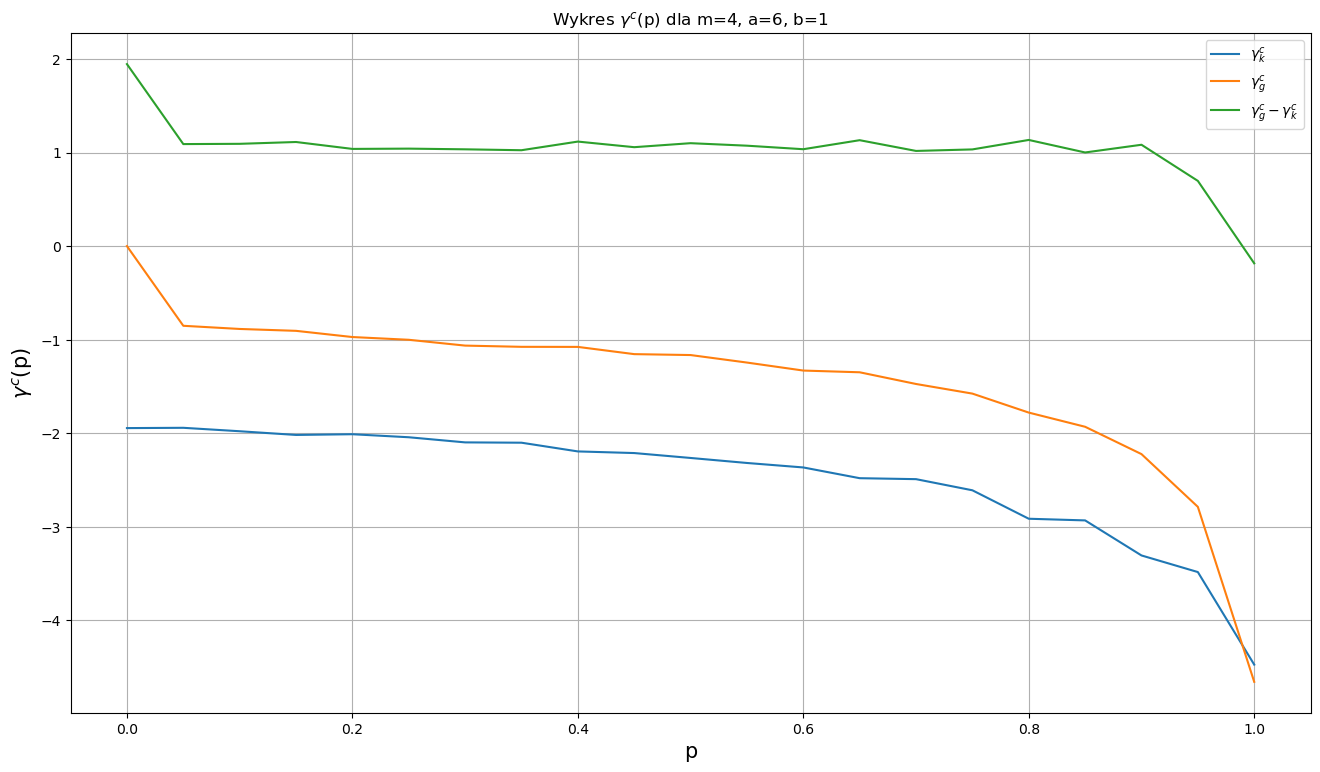

In [ ]:
plt.figure(figsize=(16,9),dpi= 100)
plt.plot(np.arange(0,1.02,0.05),gamma_list, label=f'$\gamma_k^c$')
plt.plot(np.arange(0,1.02,0.05),gamma_list_groups,label=f'$\gamma_g^c$')
plt.plot(np.arange(0,1.02,0.05),np.array(gamma_list_groups)-np.array(gamma_list),label=f'$\gamma_g^c-\gamma_k^c$')
plt.grid()
plt.xlabel("p",fontsize=15)
plt.ylabel(f"$\gamma^c$(p)",fontsize=15)
plt.title(f"Wykres $\gamma^c$(p) dla m={m}, a={a}, b={b}")
plt.legend()

# Fractal dimension

In [8]:
#check if node list was saved correctly
def open_file(file_name):
    with open(file_name, 'r') as data:
        xx = []
        for line in data:
            p = line.split()
            xx.append([int(p[0]),int(p[1])])

    return (xx)

In [9]:
def convertToAdjList(edges):
    graph={}
    for edge in edges:
        aa, bb = edge
        if not (aa in graph):
            graph[aa]=[]
        if not (bb in graph):
            graph[bb]=[]
        graph[aa].append(bb)
        graph[bb].append(aa)
    return graph

In [10]:
def convertNodeListToAdjList(node_list):
    graph={}
    for aa, bb in zip(node_list[::2],node_list[1::2]):
        
        if not (aa in graph):
            graph[aa]=[]
        if not (bb in graph):
            graph[bb]=[]
        graph[aa].append(bb)
        graph[bb].append(aa)
    return graph

In [11]:
@jit(nopython=True)
def shortestPathNeighbours(graph,source,destination):
    visited=Dict.empty(
    types.int64,
    value_type=types.int8,
    )
    distances= destination.copy()
    queue=List.empty_list(types.int64)
    queue.append(source)
    # add zero distance
    queue.append(0)
    visited[queue[0]]=1
    counter=0
    while(len(queue)>0 and (len(destination)-counter)!=0):
        currrent=queue.pop(0)
        dist=queue.pop(0)
        
        for neighbour in graph[currrent]:
            if neighbour not in visited:
                queue.append(neighbour)
                queue.append(dist+1)
                visited[neighbour]=1
                distances[neighbour]=dist+1
                if neighbour in destination:
                    counter+=1
                 
    return distances
    

In [12]:
def largestComponent(graph):
    visited=set()
    temp=set()
    largest=set()
    max=0
    for node in graph:
        val=exploreSize(graph,node,visited,temp)
        if val>max:
            max=val
            largest=temp
            temp=set()
    return max, largest
        
def exploreSize(graph,node,visited,temp):
    if node in visited:
        return 0
    visited.add(node)
    temp.add(node)
    size=1
    for neighbour in graph[node]:
        size+=exploreSize(graph,neighbour,visited,temp)
    
    return size

In [13]:
def BFS(graph,source, visited, temp):
    distances=[]
    queue=[(source,0)]
    visited.add(source)
    temp.add(source)
    while(len(queue)>0):
        currrent, dist=queue.pop(0)
        
        for neighbour in graph[currrent]:
            if neighbour not in visited:
                queue.append((neighbour,dist+1))
                distances.append((neighbour,dist+1))
                visited.add(neighbour)
                temp.add(neighbour)
    return distances

    
def largestComponentBFS(graph):
    visited=set()
    temp=set()
    largest=set()
    max=0
    for node in graph:
        if node not in visited:
            val=len(BFS(graph,node,visited,temp))
            if val>max:
                max=val
                largest=temp
                temp=set()
    return max, largest

In [14]:
@jit(nopython=True, nogil=True)
def color_graph(nb_dct,l_max,progress):
    destination= Dict.empty(
        types.int64,
        value_type=types.int16,
    )
    color=np.zeros(shape=(l_max,len(nb_dct)),dtype=np.int32)
    for node_id in np.arange(1,len(nb_dct)):
        destination[node_id-1]=9999
        dist=shortestPathNeighbours(nb_dct,node_id,destination)
        for l_b in np.arange(l_max):
            m=np.zeros(len(nb_dct),dtype=np.int32)
            for id in np.arange(node_id):
                if dist[id]>=l_b+1:
                    m[color[l_b,id]]=1
            cnt=0
            while m[cnt]:
                cnt+=1

            color[l_b,node_id]=cnt
    
        progress.update(1)
    return color

In [18]:
from numba.types import float32, unicode_type, ListType
from numba_progress import ProgressBar

initial_nodes=4
n_nodes=10**6
a=2
b=2
m=a+2
p=0.6

node_list=List.empty_list(types.int32)

group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)

group_size_dict = Dict.empty(
key_type=types.int64,
value_type=types.int64,
)
nested_3 = ListType(types.int32)
nb_dct = Dict.empty(
    types.int64,
value_type=nested_3,
)

groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

initialize_graph(node_list, group_dict, groups, initial_nodes)
for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
    proportional_attach(node_list,group_dict,groups,m,a,b,p)


graph=convertNodeListToAdjList(node_list)
val, s1=largestComponent(graph)
print(val)
val, s2=largestComponentBFS(graph)
print(val)

100%|██████████| 250000/250000 [00:03<00:00, 67636.83it/s]


1593
1592


In [27]:
np.zeros((10,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

100%|█████████▉| 4432.0/4433 [00:29<00:00, 148.13it/s]
100%|█████████▉| 5172.0/5173 [00:59<00:00, 87.09it/s] 
100%|█████████▉| 3124.0/3125 [00:14<00:00, 211.13it/s]
100%|█████████▉| 5080.0/5081 [00:41<00:00, 121.42it/s]
100%|█████████▉| 3964.0/3965 [00:11<00:00, 331.09it/s]
100%|█████████▉| 5822.0/5823 [00:51<00:00, 113.28it/s]
100%|█████████▉| 6837.0/6838 [01:22<00:00, 82.55it/s] 
100%|█████████▉| 3296.0/3297 [00:15<00:00, 216.22it/s]
100%|█████████▉| 3095.0/3096 [00:14<00:00, 214.80it/s]
100%|█████████▉| 3286.0/3287 [00:13<00:00, 239.42it/s]
100%|█████████▉| 2305.0/2306 [00:07<00:00, 318.92it/s]
100%|█████████▉| 2987.0/2988 [00:06<00:00, 490.85it/s]
100%|█████████▉| 2248.0/2249 [00:07<00:00, 284.15it/s]
100%|█████████▉| 2050.0/2051 [00:05<00:00, 357.87it/s]
100%|█████████▉| 3483.0/3484 [00:09<00:00, 378.52it/s]
100%|█████████▉| 2520.0/2521 [00:09<00:00, 263.64it/s]
100%|█████████▉| 3607.0/3608 [00:17<00:00, 207.78it/s]
100%|█████████▉| 2507.0/2508 [00:09<00:00, 253.12it/s]
100%|█████

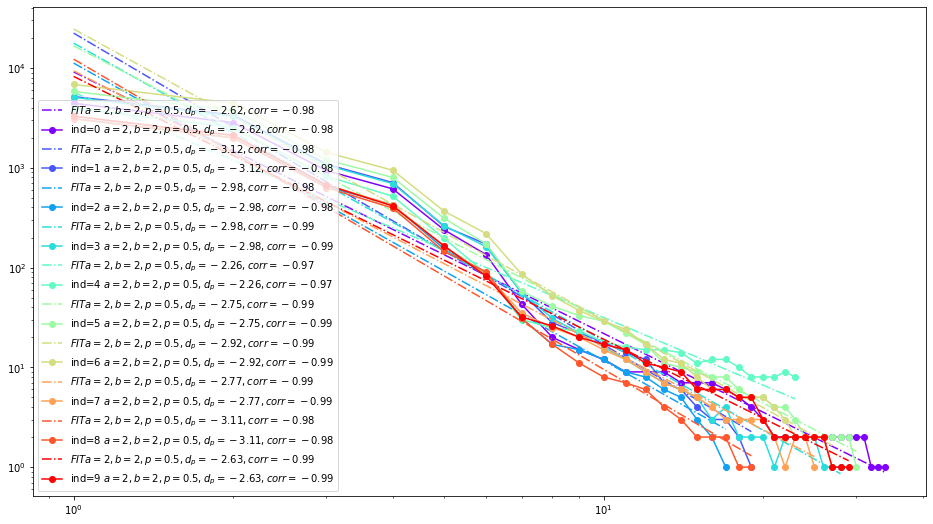

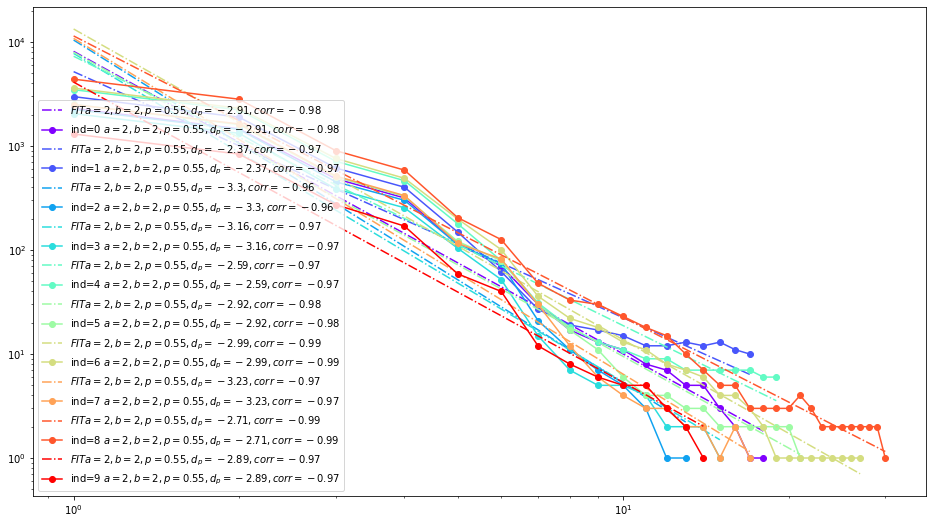

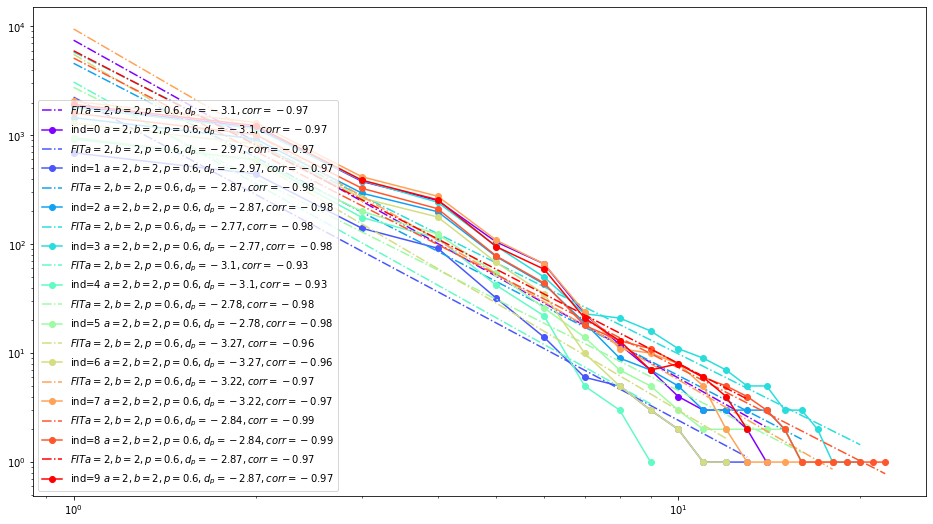

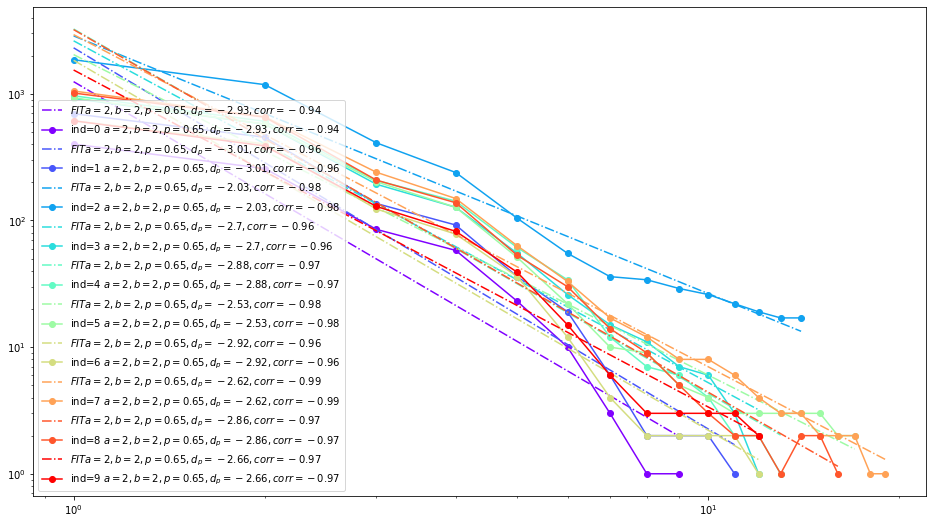

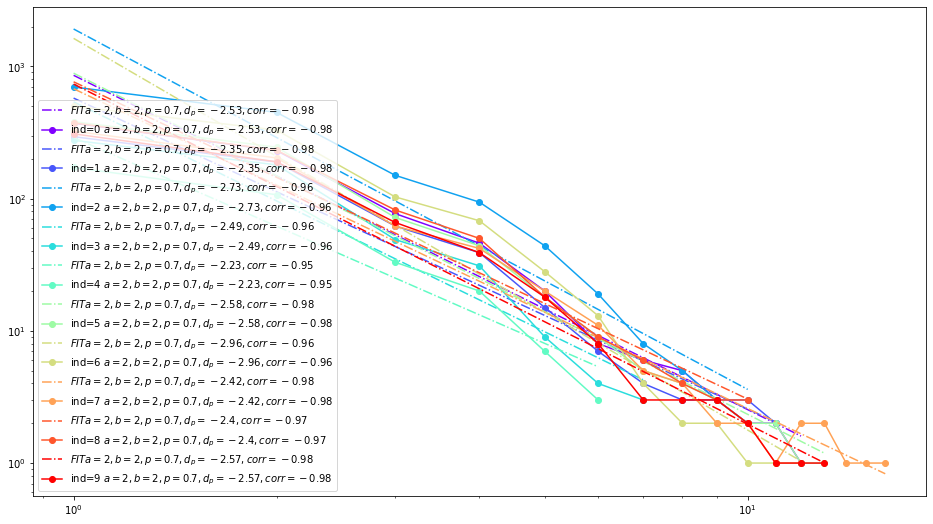

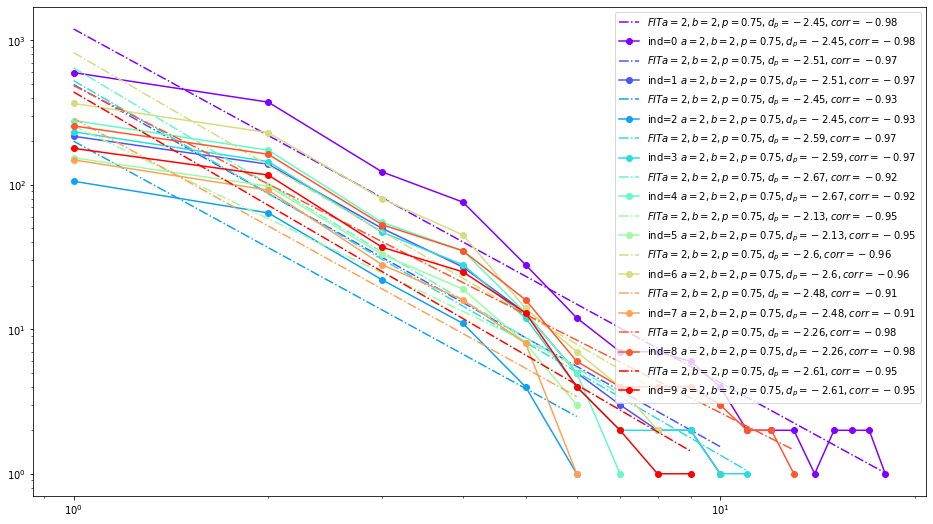

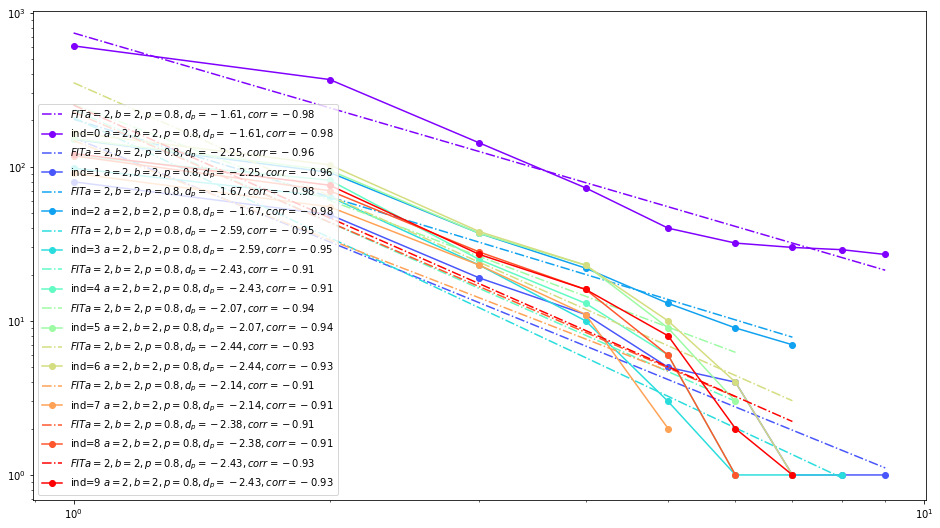

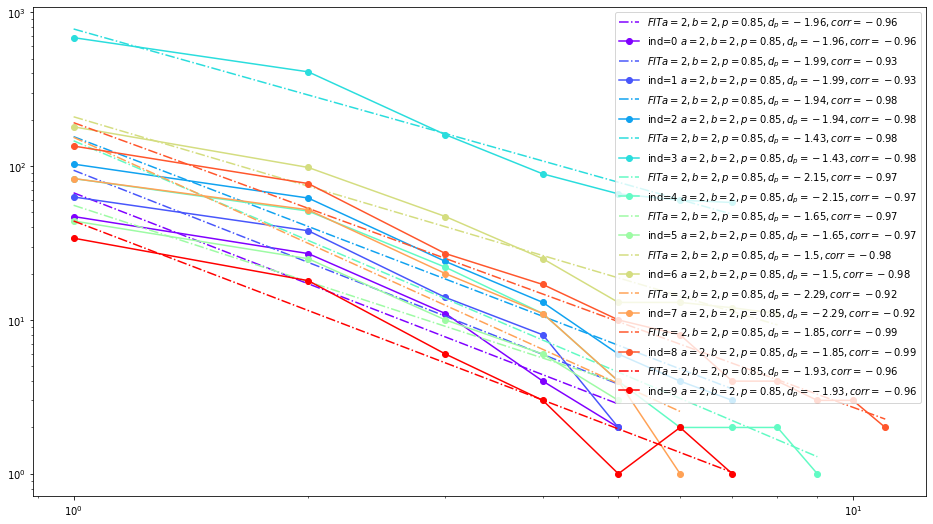

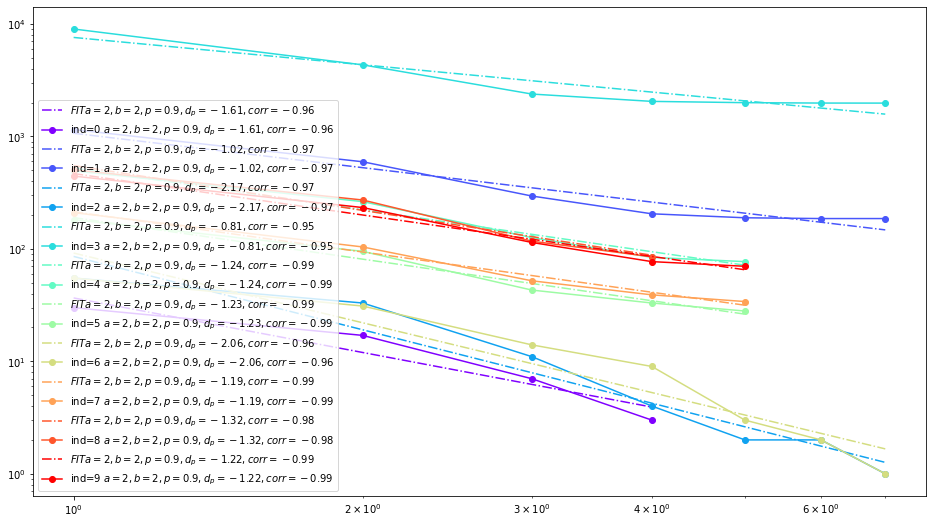

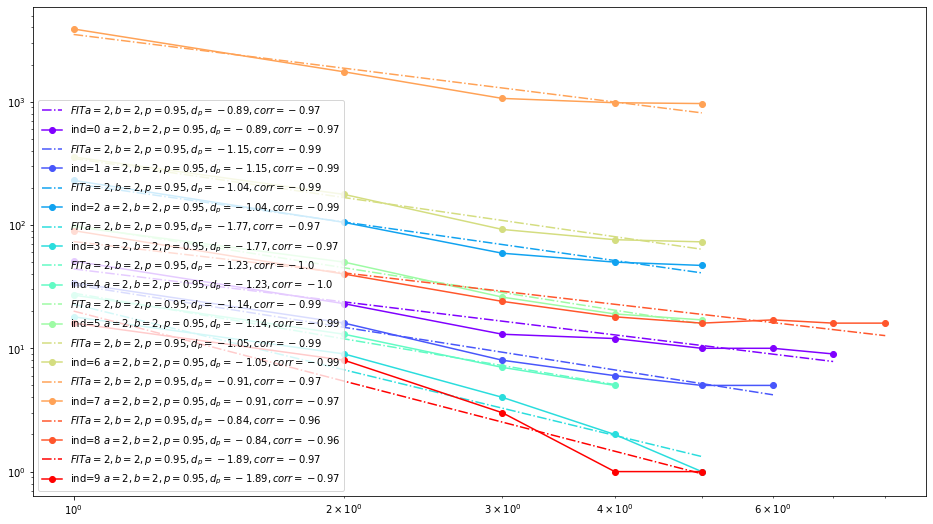

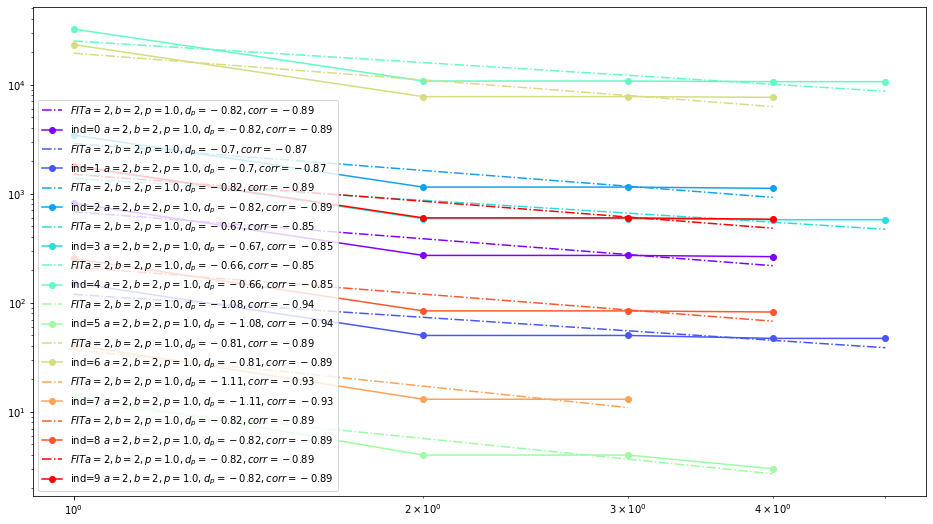

In [198]:
from numba.types import float32, unicode_type, ListType
from numba_progress import ProgressBar
from matplotlib.pyplot import cm
initial_nodes=4
n_nodes=10**5
a=2
b=2
m=a+1
# m=a+2
p=0.6
fractal_dim=np.zeros((20,10))
correlations=np.zeros((20,10))
n_iter=10
color = cm.rainbow(np.linspace(0, 1, 10))
min_param=0.5
max_param=1.01
step=0.05
params=np.arange(min_param,max_param,step)
for jj, p in (enumerate(params)):
    plt.figure(figsize=(16,9))
    for kk in (np.arange(n_iter)):
        node_list=List.empty_list(types.int32)

        group_dict = Dict.empty(
            key_type=types.int64,
            value_type=types.int64,
        )

        group_size_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
        )
        nested_3 = ListType(types.int32)
        nb_dct = Dict.empty(
            types.int64,
        value_type=nested_3,
        )

        groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

        initialize_graph(node_list, group_dict, groups, initial_nodes)
        for n_number in (np.arange(initial_nodes,n_nodes+initial_nodes,m)):
            proportional_attach(node_list,group_dict,groups,m,a,b,p)


        graph=convertNodeListToAdjList(node_list)

        val, s=largestComponentBFS(graph)
        
        sub_graph=dict((k, graph[k]) for k in s)

        tmp_node_list=[]
        for node, neighbours in sub_graph.items():
            for neighbour in neighbours:
                tmp_node_list.append(node)
                tmp_node_list.append(neighbour)
        keys=list(set(tmp_node_list))
        vals=np.arange(len(keys))
        mapping_table=dict(zip(keys,vals))

        for ii, value in enumerate(tmp_node_list):
            tmp_node_list[ii]=mapping_table[value]
            
        sub_graph=convertNodeListToAdjList(tmp_node_list)

        for node, neighbours in sub_graph.items():
            out_lst = List(lsttype=nested_3)
            for neighbour in neighbours:
                out_lst.append(neighbour)
            nb_dct[node]=out_lst

        num_iterations=len(nb_dct)
        l_b=50
        with ProgressBar(total=num_iterations) as progress:
            c=color_graph(nb_dct,l_b,progress)
            
        
        vals=np.arange(1,l_b+1)
        box_size=[]
        for row in c:
            box_size.append(np.max(row))
        box_size=np.array(box_size)
        vals=vals[box_size>box_size[l_b-1]]
        box_size=box_size[box_size>box_size[l_b-1]]
        
        # if corr<-0.6:
        logx = np.log(vals)
        logy = np.log(box_size)
        corr=np.corrcoef(logx,logy)[0,1]
        correlations[jj][kk]=corr
        coeffs = np.polyfit(logx,logy,deg=1)
        d_f=coeffs[0]
        fractal_dim[jj][kk]=d_f
        poly = np.poly1d(coeffs)
        yfit = lambda x: np.exp(poly(np.log(x)))
        plt.loglog(vals,yfit(vals),"-.",c=color[kk])
        plt.loglog(vals,box_size,"o-",c=color[kk],label=f"ind={kk} $a={a}, b={b}, p={np.round(p,2)}, d_p={np.round(d_f,2)}, corr={np.round(corr,2)}$")
        plt.legend()

    

In [202]:
from numba.types import float32, unicode_type, ListType
from numba_progress import ProgressBar
from matplotlib.pyplot import cm
initial_nodes=4
n_nodes=10**6
a=2
b=2
m=a+1
# m=a+2
p=0.6
fractal_dim=np.zeros((20,10))
correlations=np.zeros((20,10))
n_iter=10
color = cm.rainbow(np.linspace(0, 1, 10))
min_param=0.5
max_param=1.01
step=0.05
params=np.arange(min_param,max_param,step)
for jj, b in (enumerate(np.array([1,2,5,10,20,50,100]))):
    plt.figure(figsize=(16,9))
    for kk in (np.arange(n_iter)):
        node_list=List.empty_list(types.int32)

        group_dict = Dict.empty(
            key_type=types.int64,
            value_type=types.int64,
        )

        group_size_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
        )
        nested_3 = ListType(types.int32)
        nb_dct = Dict.empty(
            types.int64,
        value_type=nested_3,
        )

        groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

        initialize_graph(node_list, group_dict, groups, initial_nodes)
        for n_number in (np.arange(initial_nodes,n_nodes+initial_nodes,m)):
            proportional_attach(node_list,group_dict,groups,m,a,b,p)


        graph=convertNodeListToAdjList(node_list)

        val, s=largestComponentBFS(graph)
        
        sub_graph=dict((k, graph[k]) for k in s)

        tmp_node_list=[]
        for node, neighbours in sub_graph.items():
            for neighbour in neighbours:
                tmp_node_list.append(node)
                tmp_node_list.append(neighbour)
        keys=list(set(tmp_node_list))
        vals=np.arange(len(keys))
        mapping_table=dict(zip(keys,vals))

        for ii, value in enumerate(tmp_node_list):
            tmp_node_list[ii]=mapping_table[value]
            
        sub_graph=convertNodeListToAdjList(tmp_node_list)

        for node, neighbours in sub_graph.items():
            out_lst = List(lsttype=nested_3)
            for neighbour in neighbours:
                out_lst.append(neighbour)
            nb_dct[node]=out_lst

        num_iterations=len(nb_dct)
        l_b=50
        with ProgressBar(total=num_iterations) as progress:
            c=color_graph(nb_dct,l_b,progress)
            
        
        vals=np.arange(1,l_b+1)
        box_size=[]
        for row in c:
            box_size.append(np.max(row))
        box_size=np.array(box_size)
        vals=vals[box_size>box_size[l_b-1]]
        box_size=box_size[box_size>box_size[l_b-1]]
        
        # if corr<-0.6:
        logx = np.log(vals)
        logy = np.log(box_size)
        corr=np.corrcoef(logx,logy)[0,1]
        correlations[jj][kk]=corr
        coeffs = np.polyfit(logx,logy,deg=1)
        d_f=coeffs[0]
        fractal_dim[jj][kk]=d_f
        poly = np.poly1d(coeffs)
        yfit = lambda x: np.exp(poly(np.log(x)))
        plt.loglog(vals,yfit(vals),"-.",c=color[kk])
        plt.loglog(vals,box_size,"o-",c=color[kk],label=f"ind={kk} $a={a}, b={b}, p={np.round(p,2)}, d_p={np.round(d_f,2)}, corr={np.round(corr,2)}$")
        plt.legend()

    

100%|█████████▉| 2695.0/2696 [00:13<00:00, 200.84it/s]
100%|█████████▉| 10274.0/10275 [06:05<00:00, 28.08it/s]
100%|█████████▉| 6158.0/6159 [01:53<00:00, 54.19it/s]
100%|█████████▉| 4341.0/4342 [00:39<00:00, 109.05it/s]
100%|█████████▉| 4155.0/4156 [00:31<00:00, 133.42it/s]
100%|█████████▉| 3570.0/3571 [00:24<00:00, 148.36it/s]
100%|█████████▉| 3361.0/3362 [00:19<00:00, 172.47it/s]
100%|█████████▉| 4404.0/4405 [00:33<00:00, 130.28it/s]
100%|█████████▉| 10662.0/10663 [01:06<00:00, 160.38it/s]
100%|█████████▉| 5616.0/5617 [00:41<00:00, 135.58it/s]
100%|█████████▉| 5945.0/5946 [01:01<00:00, 96.29it/s] 
100%|█████████▉| 4393.0/4394 [00:34<00:00, 126.62it/s]
100%|█████████▉| 3857.0/3858 [00:24<00:00, 155.38it/s]
100%|█████████▉| 15211.0/15212 [13:16<00:00, 19.09it/s]
100%|█████████▉| 9183.0/9184 [01:20<00:00, 113.67it/s]
100%|█████████▉| 7646.0/7647 [00:42<00:00, 181.31it/s]
100%|█████████▉| 4303.0/4304 [00:32<00:00, 131.33it/s]
100%|█████████▉| 5515.0/5516 [01:15<00:00, 72.86it/s]
100%|███

In [200]:
from statsmodels.stats.weightstats import ztest as ztest
import pandas as pd
results=pd.DataFrame()
results['df']=fractal_dim.mean(axis=1)
results['sd_df']=fractal_dim.std(axis=1)
results['corr']=correlations.mean(axis=1)
results['corr_std']=correlations.std(axis=1)
z_s=[]
p_vals=[]
val=-1
# params=np.arange(min_param,max_param,step)
for ii in np.arange(20):
    data=correlations[ii,:]
    z,p_val=ztest(data, value=val,alternative='smaller')
    z_s+=[z]
    p_vals+=[p_val]
results['Z']=z_s
results['p_val']=p_val
results['b']=[1,2,5,10,20,50,100]

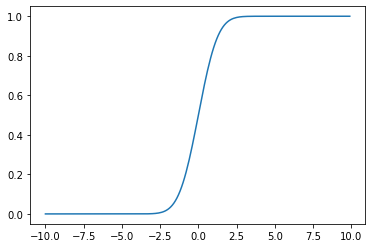

In [189]:
from scipy.stats import norm
m=np.mean(correlations[10,:])
sd=np.std((correlations[10,:]))
norm.cdf((m-(-1))/(sd/np.sqrt(len(correlations[10,:]))))
plt.plot(np.arange(-10,10,0.1),norm.cdf(np.arange(-10,10,0.1)))

In [177]:
data=[1,1.001,1,1,1.002]
val=1.00
z,p_val=ztest(data, value=val,alternative='smaller')
p_val

0.933192798731123

In [201]:
results

,df,sd_df,corr,corr_std,Z,p_val
0,-2.814168,0.252336,-0.983446,0.006100,8.141285,1.0
1,-2.905669,0.275795,-0.975159,0.008596,8.669201,1.0
2,-2.978773,0.171614,-0.969804,0.014167,6.394406,1.0
3,-2.715630,0.271089,-0.967494,0.014254,6.841527,1.0
4,-2.525465,0.195826,-0.969553,0.010670,8.560072,1.0
5,-2.474213,0.157371,-0.951627,0.023748,6.110834,1.0
6,-2.201166,0.314902,-0.939910,0.026831,6.718700,1.0
7,-1.869284,0.259419,-0.963869,0.020635,5.252746,1.0
8,-1.386737,0.412827,-0.975495,0.015364,4.784992,1.0
9,-1.190661,0.340212,-0.979192,0.011944,5.226590,1.0


In [ ]:
np.arange(0.05,0.4,0.05)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35])

In [ ]:
print()

[0.19175913 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [109]:
sd=correlations.std(axis=1)[0]
m=
(m-(-1))/(sd)

1.8028319876936778

In [97]:
print(correlations.mean(axis=1))

[-0.95217618 -0.96271306  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [98]:
print(correlations.std(axis=1))

[0.02652705 0.01119825 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [62]:
# prob=counts/np.sum(counts)


In [ ]:
np.corrcoef(x,y)[0,1]

-0.753300075414778
-1.0
-0.9527359791892003


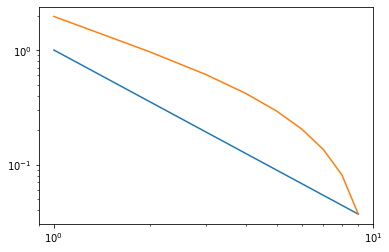

In [80]:
x=(np.arange(1,10))
y=(x**(-1.5))
cum_sum=np.cumsum(y[::-1])[::-1]
print(np.corrcoef(x,y)[0,1])
log_x=np.log(x)
log_y=np.log(y)
log_cum_y=np.log(cum_sum)
print(np.corrcoef(log_x,log_y)[0,1])
print(np.corrcoef(log_x,log_cum_y)[0,1])
plt.loglog(x,y)
plt.loglog(x,cum_sum)

-0.8853328843707845
-0.9549188970340978
-0.9279074563682584


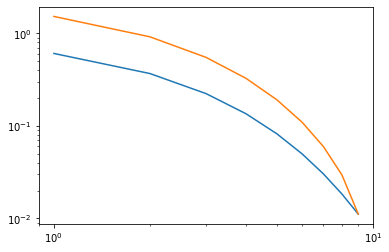

In [78]:
x=(np.arange(1,10))
y=(np.exp(x*-0.5))
cum_sum=np.cumsum(y[::-1])[::-1]
print(np.corrcoef(x,y)[0,1])
log_x=np.log(x)
log_y=np.log(y)
log_cum_y=np.log(cum_sum)
print(np.corrcoef(log_x,log_y)[0,1])
print(np.corrcoef(log_x,log_cum_y)[0,1])
plt.loglog(x,y)
plt.loglog(x,cum_sum)

-0.5038494904278058
-0.9924053649445487
-0.9698513328362676


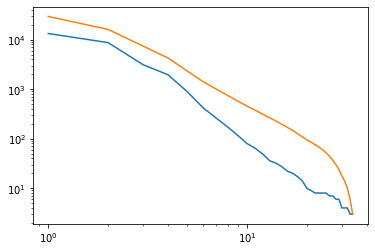

In [81]:
x=vals
y=box_size
cum_sum=np.cumsum(y[::-1])[::-1]
print(np.corrcoef(x,y)[0,1])
log_x=np.log(x)
log_y=np.log(y)
log_cum_y=np.log(cum_sum)
print(np.corrcoef(log_x,log_y)[0,1])
print(np.corrcoef(log_x,log_cum_y)[0,1])
plt.loglog(x,y)
plt.loglog(x,cum_sum)

In [44]:
np.corrcoef(np.log(x),np.log(y))[0,1]

-1.0

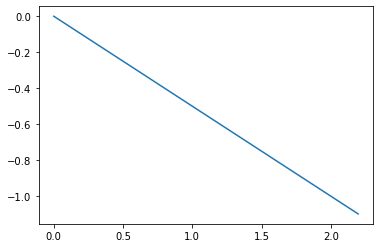

In [45]:
plt.plot(np.log(x),np.log(y))

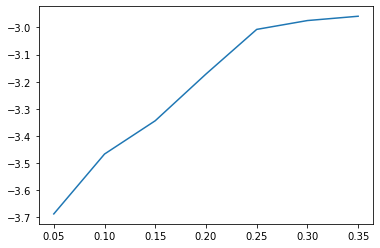

In [17]:
plt.plot(np.arange(0.05,0.4,0.05),fractal_dim.mean(axis=1)[:7])

In [40]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

100%|█████████▉| 13311.0/13312 [04:25<00:00, 50.16it/s]


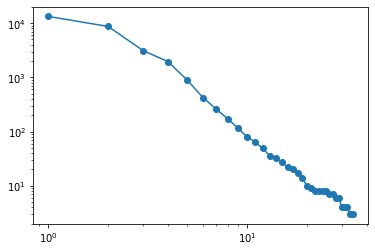

In [55]:
xx = open_file('dane1.txt')
graph=convertToAdjList(xx)

node_list=List.empty_list(types.int32)

group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)

group_size_dict = Dict.empty(
key_type=types.int64,
value_type=types.int64,
)
nested_3 = ListType(types.int32)
nb_dct = Dict.empty(
    types.int64,
value_type=nested_3,
)

val, s=largestComponentBFS(graph)

sub_graph=dict((k, graph[k]) for k in s)

tmp_node_list=[]
for node, neighbours in sub_graph.items():
    for neighbour in neighbours:
        tmp_node_list.append(node)
        tmp_node_list.append(neighbour)
keys=list(set(tmp_node_list))
vals=np.arange(len(keys))
mapping_table=dict(zip(keys,vals))

for ii, value in enumerate(tmp_node_list):
    tmp_node_list[ii]=mapping_table[value]
    
sub_graph=convertNodeListToAdjList(tmp_node_list)

for node, neighbours in sub_graph.items():
    out_lst = List(lsttype=nested_3)
    for neighbour in neighbours:
        out_lst.append(neighbour)
    nb_dct[node]=out_lst

num_iterations=len(nb_dct)
l_b=50
with ProgressBar(total=num_iterations) as progress:
    c=color_graph(nb_dct,l_b,progress)
    

vals=np.arange(1,l_b+1)
box_size=[]
for row in c:
    box_size.append(np.max(row))
box_size=np.array(box_size)
vals=vals[box_size>box_size[l_b-1]]
box_size=box_size[box_size>box_size[l_b-1]]

# if corr<-0.6:
logx = np.log(vals)
logy = np.log(box_size)
corr=np.corrcoef(logx,logy)[0,1]
correlations[jj][kk]=corr
coeffs = np.polyfit(logx,logy,deg=1)
d_f=coeffs[0]
fractal_dim[jj][kk]=d_f
plt.loglog(vals,box_size,"o-",label=f"$a={a}, b={b}, p={np.round(p,2)}, d_p={np.round(d_f,2)}, corr={np.round(corr,2)}$")

In [58]:
corr

-0.9924053649445487

d_f=-0.15


Text(0.5, 1.0, 'Zależność liczby pudełek potrzebnych do pokrycia sieci w zależności od rozmiaru pudełka')

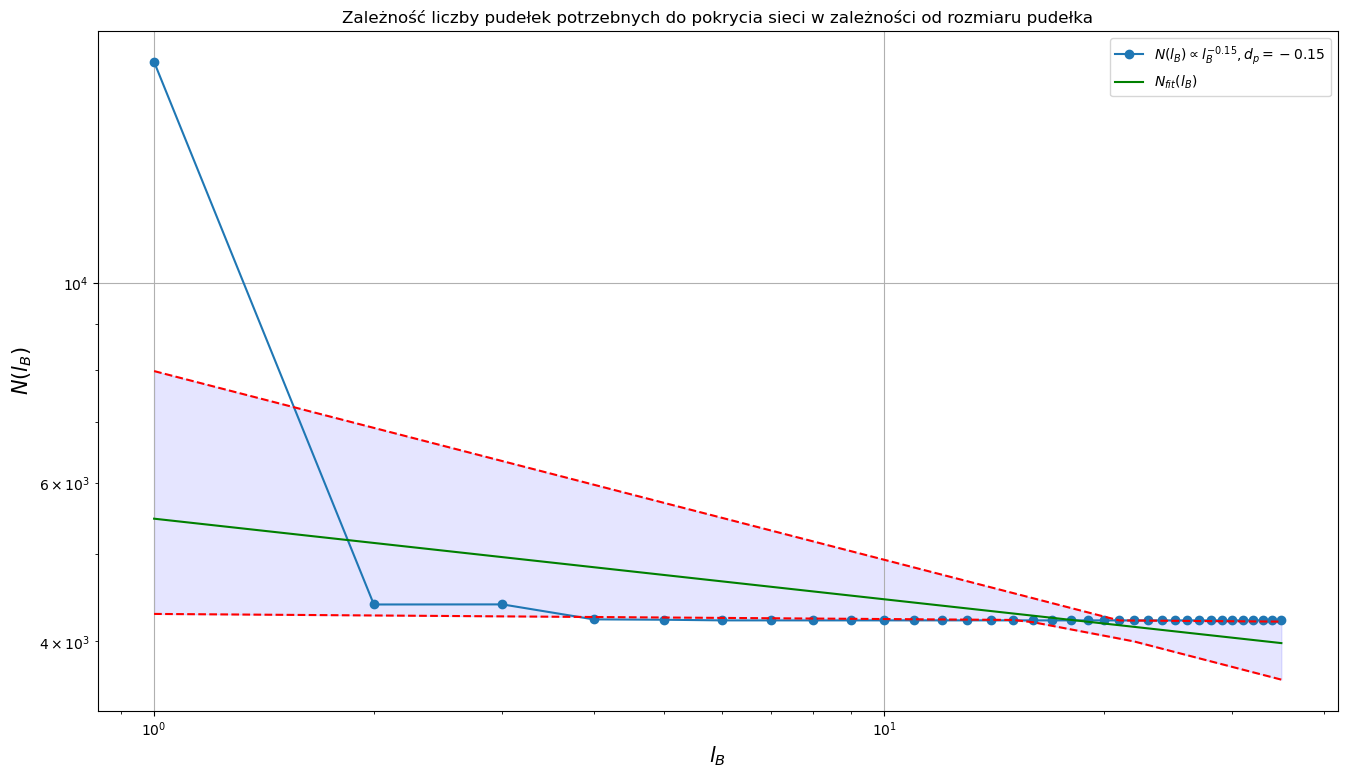

In [131]:
from mlinsights.mlmodel import IntervalRegressor
from sklearn.linear_model import LinearRegression


# plt.loglog(vals,cum_sum,"^-",label="Cumulated P(G)")

logx = np.log(vals)
logy = np.log(box_size)
coeffs = np.polyfit(logx,logy,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))
d_f=np.round(coeffs[0],2)

lin = IntervalRegressor(LinearRegression())
logx=logx.reshape(-1, 1)
lin.fit(logx, (logy))
sorted_X = np.array(list(sorted(logx)))
pred = lin.predict(sorted_X)
bootstrapped_pred = lin.predict_sorted(sorted_X)
min_pred = bootstrapped_pred[:, 0]
max_pred = bootstrapped_pred[:, bootstrapped_pred.shape[1]-1]
sor_x=np.array([ val[0] for val in sorted_X])



print(f'd_f={d_f}')
plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,box_size,"o-",label=f"$N(l_B) \propto l_B^{{{d_f}}}, d_p={d_f}$")
plt.loglog(vals, np.exp(pred), label=f"$N_{{fit}}(l_B)$",color='g')
plt.loglog(vals,np.exp(min_pred),'--',color='r')
plt.loglog(vals,np.exp(max_pred),'--',color='r')
plt.fill_between(vals, np.exp(min_pred),np.exp(max_pred),color='b',alpha=.1)
plt.legend()
plt.grid()
plt.xlabel(f"$l_B$",fontsize=15)
plt.ylabel(f"$N(l_B)$",fontsize=15)
plt.title(f"Zależność liczby pudełek potrzebnych do pokrycia sieci w zależności od rozmiaru pudełka")

In [78]:
destination= Dict.empty(
    types.int64,
    value_type=types.int8,
)
l_max=3
col_tmp=np.zeros(shape=l_max)
color=np.zeros(shape=(l_max,len(graph)),dtype=np.int32)
for node_id in tqdm(np.arange(1,len(graph))):
    destination[node_id-1]=node_id-1
    dist=shortestPathNeighbours(nb_dct,node_id,destination)
    for l_b in np.arange(l_max):
        l=[]
        for id in np.arange(node_id):
            # print(f'lmax: {l_max} node_id: {node_id} id: {id} dist[id] {dist[id]}')
            if dist[id]>=l_b+1:
               l+=[color[l_b,id]]
                # color[l_b,node_id]=color[l_b,id]+1
        m = range(0,node_id+1)
        # print(set(m),set(l))
        color[l_b,node_id]=min(set(m)-set(l))

                # print(color)
col_tmp
            

100%|██████████| 6/6 [00:00<00:00, 2999.86it/s]


array([0., 0., 0.])

In [120]:
n_box=[]
color=c
for row in color:
    n_box+=[len(np.unique(row))]
n_box

[13312, 8715, 3121, 1960, 896, 426, 261, 173, 117, 81]

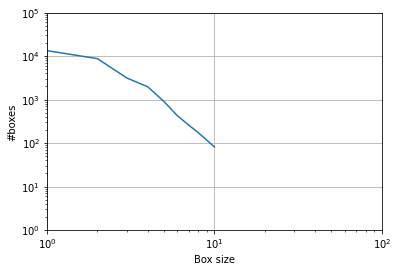

In [121]:
plt.loglog(1+np.arange(10),n_box)
plt.xlabel("Box size")
plt.ylabel("#boxes")
plt.ylim((1,10**5))
plt.xlim((1,10**2))
plt.grid()

In [ ]:
graph={0:[6,1,5],
       1:[0],
       5:[0,6],
       6:[0,5],
       2:[3,4],
       3:[2,4],
       4:[3,2]}
edges=[[0,6],[0,1],[0,5],[6,5],[2,3],[2,4],[3,4]]

In [ ]:
nested_3 = ListType(types.int32)
nb_dct = Dict.empty(
    types.int64,
   value_type=nested_3,
)

for node, neighbours in graph.items():
    out_lst = List(lsttype=nested_3)
    for neighbour in neighbours:
        out_lst.append(neighbour)
    nb_dct[node]=out_lst

In [ ]:
num_iterations=len(nb_dct)
l_b=100
with ProgressBar(total=num_iterations) as progress:
    c=color_graph(nb_dct,l_b,progress)

In [81]:
import networkx as nx
nx_graph=nx.Graph(graph)
H = nx.Graph()
H.add_nodes_from(sorted(nx_graph.nodes(data=True)))
H.add_edges_from(nx_graph.edges(data=True))
pos = nx.spring_layout(H,k=1)


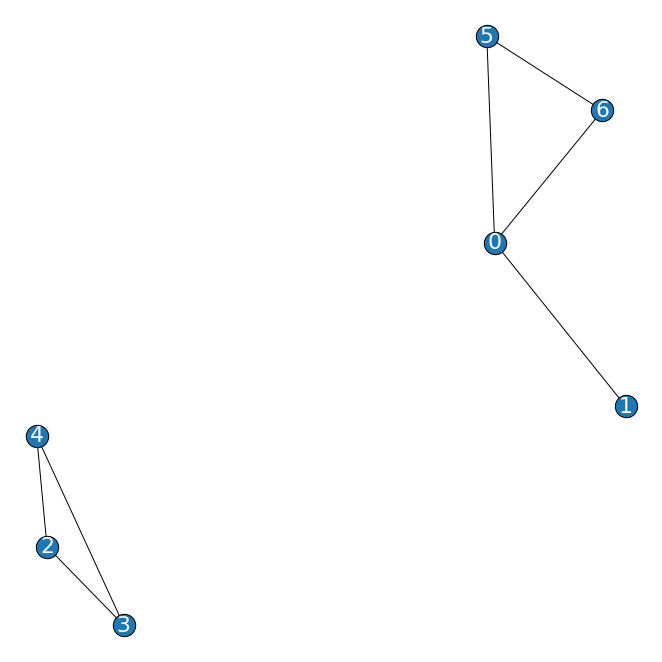

In [91]:
plt.figure(figsize=(9,9))
nx.draw(H,pos=pos,label=graph, font_size=22, font_color="white", with_labels=True,node_shape='o',edgecolors='black',node_size=500)

In [93]:
print(color)

[[0 1 2 3 4 5 6]
 [0 0 1 1 1 2 2]
 [0 0 1 1 1 0 0]]


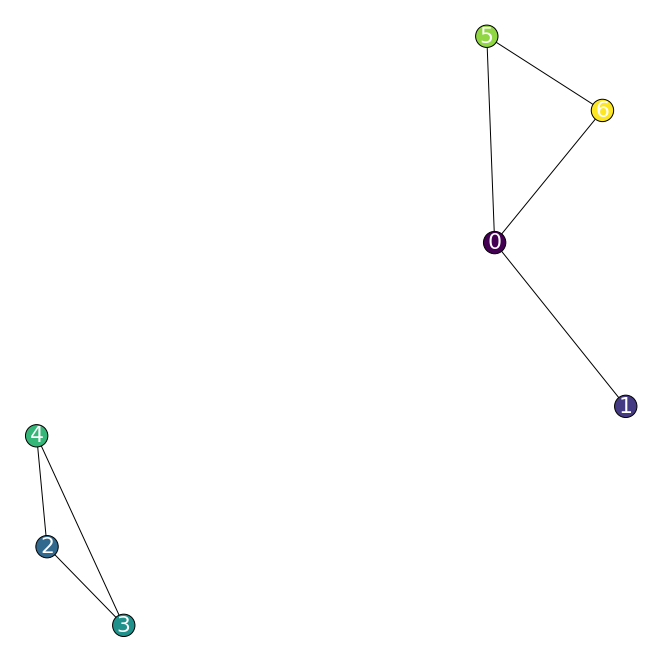

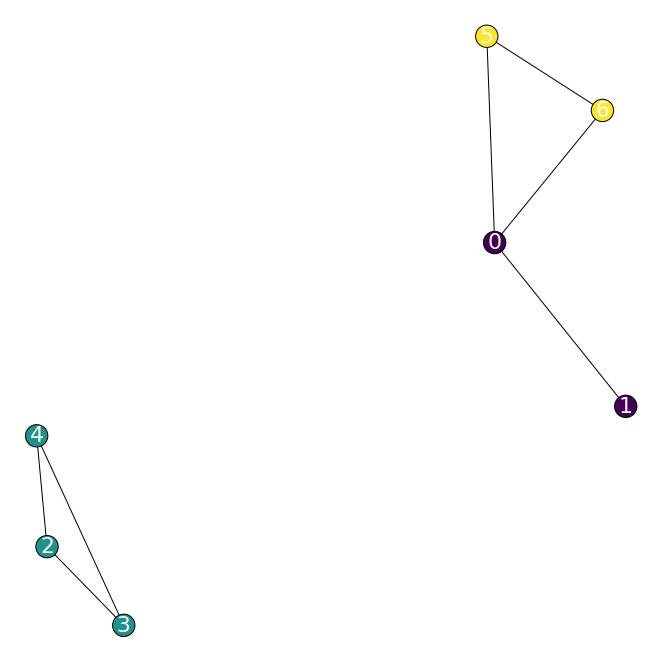

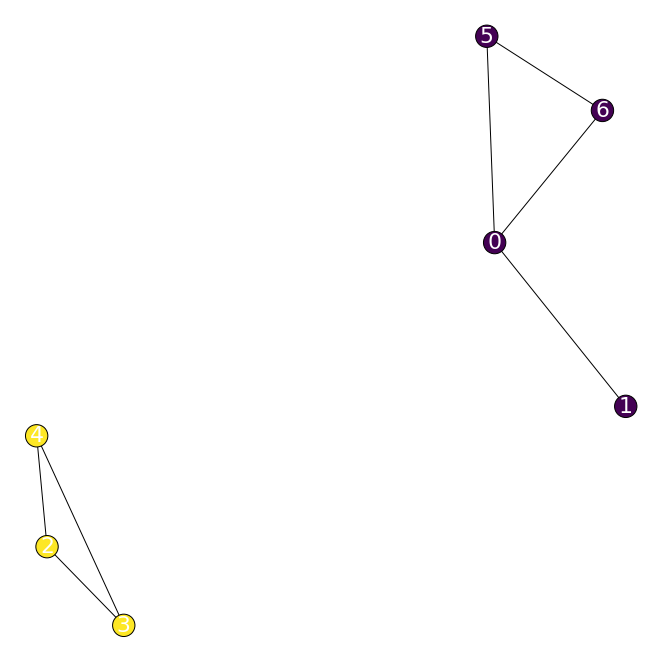

In [88]:
color=c
for row in color:
    plt.figure(figsize=(9,9))
    nx.draw(H,pos=pos,label=graph, font_size=22, font_color="white", with_labels=True,node_color=row,node_shape='o',edgecolors='black',node_size=500)

In [180]:
col_tot=np.arange(len(graph))
col_dict=dict(zip(col_tot,col_tot))

In [173]:
col_tmp=col_tot-col_tmp
col_tmp

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
@jit(nopython=True)
def set_difference(m,l):
    for element1 in m:
        if element1 not in l:
            return element1

In [77]:
destination= Dict.empty(
    types.int64,
    value_type=types.int8,
    )
destination[1]=1
destination[10000]=1

In [ ]:
destination= Dict.empty(
    types.int64,
    value_type=types.int8,
    )

In [78]:
d=shortestPathNeighbours(nb_dct,10,destination=destination)
d

DictType[int64,int8]<iv=None>({10: 0, 1: 1, 10000: 3})

In [ ]:
# @jit(nopython=True)
def shortestPathNeighbours_collections(graph,source,destination):
    visited=Dict.empty(
    types.int64,
    value_type=types.int8,
    )
    distances= destination.copy()
    queue=deque()
    queue.append((source,0))
    visited[source]=1
    counter=0
    while(len(queue)>0 and (len(destination)-counter)!=0):
        currrent, dist=queue.popleft()
        
        for neighbour in graph[currrent]:
            if neighbour not in visited:
                queue.append((neighbour,dist+1))
                visited[neighbour]=1
                distances[neighbour]=dist+1
                if neighbour in destination:
                    # counter+=1
                    counter+=0
                 
    return distances
    

In [ ]:
def BFS(graph,source):
    visited=set()
    distances=[]
    queue=[(source,0)]
    visited.add(queue[0])
    while(len(queue)>0):
        currrent, dist=queue.pop(0)
        print(currrent)
        
        for neighbour in graph[source]:
            if neighbour not in visited:
                queue.append((neighbour,dist+1))
                distances.append((neighbour,dist+1))
                visited.add(neighbour)
    return distances
    

46541.520000000004

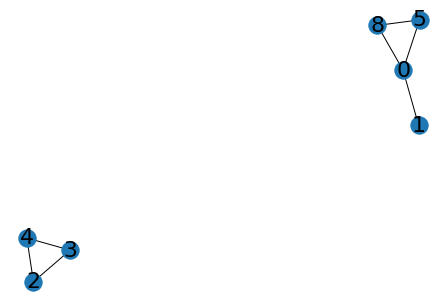